# Training

**The objective is to see how indicators impact the economy and how it reflects on precious metal prices in a monthly view.**

- Metals price data (Silver, Gold, Copper, Palladium, Platinum)

- Inflation

    - Global

- US Consumer Price Index (CPI)

- Interest Rates

    - Chile

    - US

    - China

    - South Africa

    - Canada 

    - Mexico

- Oil Prices

## Load Data

In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lightgbm as lgb
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.impute import SimpleImputer

### Metals
**Precious metals impact economy through value, trade, and inflation.**

In [308]:
silver = pd.read_csv('datasets/Finance/Silver Futures Historical Data.csv')
gold = pd.read_csv('datasets/Finance/Gold Futures Historical Data.csv')
copper = pd.read_csv('datasets/Finance/Copper Futures Historical Data.csv')
palladium = pd.read_csv('datasets/Finance/Palladium Futures Historical Data.csv')
platinum = pd.read_csv('datasets/Finance/Platinum Futures Historical Data.csv')
silver.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,10/18/2023,23.038,22.983,23.488,22.845,NaN,0.06%
1,10/17/2023,23.024,22.780,23.180,22.535,48.47K,1.14%
2,10/16/2023,22.765,22.910,22.910,22.635,36.55K,-0.57%
3,10/13/2023,22.895,21.985,22.990,21.960,76.26K,4.26%
4,10/12/2023,21.959,22.205,22.390,21.880,51.30K,-0.79%


In [309]:
print(f"Silver\t\t{silver.shape}")
print(f"Gold \t\t{gold.shape}")
print(f"Copper \t\t{copper.shape}")
print(f"Palladium \t{palladium.shape}")
print(f"Platinum \t{platinum.shape}")

Silver		(2746, 7)
Gold 		(2766, 7)
Copper 		(2754, 7)
Palladium 	(3024, 7)
Platinum 	(3318, 7)


### Consumer Price Index 
**US CPI measures consumer price inflation.**

In [310]:
us_cpi = pd.read_csv('datasets/Finance/us cpi/cpi.csv')
us_cpi.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2013,230.280,232.166,232.773,232.531,232.945,233.504,233.596,233.877,234.149,233.546,233.069,233.049
1,2014,233.916,234.781,236.293,237.072,237.900,238.343,238.250,237.852,238.031,237.433,236.151,234.812
2,2015,233.707,234.722,236.119,236.599,237.805,238.638,238.654,238.316,237.945,237.838,237.336,236.525
3,2016,236.916,237.111,238.132,239.261,240.229,241.018,240.628,240.849,241.428,241.729,241.353,241.432
4,2017,242.839,243.603,243.801,244.524,244.733,244.955,244.786,245.519,246.819,246.663,246.669,246.524


In [311]:
print("CPI", us_cpi.shape)

CPI (11, 13)


### Interest Rates
**Interest rates influence borrowing, spending, and investment.**

In [312]:
interest_rates = pd.read_csv("datasets/Finance/interestrates/EO_18102023022850125.csv")
interest_rates.head()

,LOCATION,Country,VARIABLE,Variable,FREQUENCY,Frequency,TIME,Time,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,CAN,Canada,IRS,Short-term interest rate,Q,Quarterly,2013-Q1,Q1-2013,PC,Percentage,0,Units,NaN,NaN,1.160000,NaN,NaN
1,CAN,Canada,IRS,Short-term interest rate,Q,Quarterly,2013-Q2,Q2-2013,PC,Percentage,0,Units,NaN,NaN,1.160667,NaN,NaN
2,CAN,Canada,IRS,Short-term interest rate,Q,Quarterly,2013-Q3,Q3-2013,PC,Percentage,0,Units,NaN,NaN,1.168424,NaN,NaN
3,CAN,Canada,IRS,Short-term interest rate,Q,Quarterly,2013-Q4,Q4-2013,PC,Percentage,0,Units,NaN,NaN,1.168606,NaN,NaN
4,CAN,Canada,IRS,Short-term interest rate,Q,Quarterly,2014-Q1,Q1-2014,PC,Percentage,0,Units,NaN,NaN,1.170000,NaN,NaN


In [313]:
print("Interest Rates", interest_rates.shape)

Interest Rates (473, 17)


### Crude Oil Prices
**Crude oil prices affect energy costs and global economy.**

In [314]:
crude_oil = pd.read_csv("datasets/Finance/oil/crude-oil-price.csv")
crude_oil.head()

,date,price,percentChange,change
0,1983-03-30T00:00:00,29.27,NaN,NaN
1,1983-04-04T00:00:00,30.63,4.646,1.36
2,1983-05-02T00:00:00,30.25,-1.241,-0.38
3,1983-06-01T00:00:00,31.38,3.736,1.13
4,1983-07-01T00:00:00,32.00,1.976,0.62


In [315]:
print("Crude Oil Prices", crude_oil.shape)

Crude Oil Prices (489, 4)


**Process Dates**

In [316]:
silver['Date'] = pd.to_datetime(silver['Date'])
gold['Date'] = pd.to_datetime(gold['Date'])
copper['Date'] = pd.to_datetime(copper['Date'])
palladium['Date'] = pd.to_datetime(palladium['Date'])
platinum['Date'] = pd.to_datetime(platinum['Date'])

In [317]:
def stringToNumber(data):
    df = data.copy()
    cols = df.columns
    for c in cols:
        if df[c].dtype == 'object':
            df[c] = df[c].str.replace('%', '')  # Remove percentage symbols
            df[c] = df[c].str.replace(',', '')  # Remove thousand separators
            df[c] = df[c].astype(float)  # Convert to float
    return df

silver[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(silver[['Price', 'Open', 'High', 'Low', 'Change %']])
gold[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(gold[['Price', 'Open', 'High', 'Low', 'Change %']])
copper[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(copper[['Price', 'Open', 'High', 'Low', 'Change %']])
palladium[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(palladium[['Price', 'Open', 'High', 'Low', 'Change %']])
platinum[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(platinum[['Price', 'Open', 'High', 'Low', 'Change %']])

In [318]:
crude_oil['date'] = pd.to_datetime(crude_oil['date'])

In [319]:
interest_rates['TIME'] = pd.to_datetime(interest_rates['TIME'].str.replace('-', ''))

In [320]:
#us_cpi['Year'] = pd.to_datetime(us_cpi['Year'])

## Clean Data

In [321]:
us_cpi = pd.melt(us_cpi, id_vars=['Year'], var_name='Month', value_name='Price')
us_cpi.head()

,Year,Month,Price
0,2013,Jan,230.280
1,2014,Jan,233.916
2,2015,Jan,233.707
3,2016,Jan,236.916
4,2017,Jan,242.839


In [322]:
us_cpi['Date'] = pd.to_datetime(us_cpi['Year'].astype(str) + '-' + us_cpi['Month'])
us_cpi.head()

,Year,Month,Price,Date
0,2013,Jan,230.280,2013-01-01
1,2014,Jan,233.916,2014-01-01
2,2015,Jan,233.707,2015-01-01
3,2016,Jan,236.916,2016-01-01
4,2017,Jan,242.839,2017-01-01


In [323]:
# Set training window
min_date = silver['Date'].min()
crude_oil = crude_oil[crude_oil['date'] >= min_date]
interest_rates = interest_rates[interest_rates['TIME'] >= min_date]
us_cpi = us_cpi[us_cpi['Date'] >= min_date]

### Plot Values

In [324]:
# Metals date reindex and imputation
plot_df = silver.set_index("Date").resample("M").Price.mean().reset_index()
px.line(plot_df, x='Date', y='Price', title='Silver Price')

In [325]:
# Metals date reindex and imputation
plot_df = gold.set_index("Date").resample("M").Price.mean().reset_index()
px.line(plot_df, x='Date', y='Price', title='Gold Price')

In [326]:
# Oil price
plot_df = crude_oil.set_index("date").resample("M").price.mean().reset_index()
px.line(plot_df, x='date', y='price', title='Crude Oil Price')

In [327]:
plot_df = us_cpi.set_index("Date").resample("M").Price.mean().reset_index()
px.line(plot_df, x='Date', y='Price', title='US CPI')

In [328]:
plot_df = interest_rates.set_index("TIME").groupby(['TIME', 'Country', "Time"]).Value.mean().reset_index()
px.line(plot_df, x='TIME', y='Value', color='Country', title='Interest Rates by Country')

### Check Distributions

In [329]:
metals = [silver, gold, copper, palladium, platinum]
metals_name = ['Silver', 'Gold', 'Copper', 'Palladium', 'Platinum']

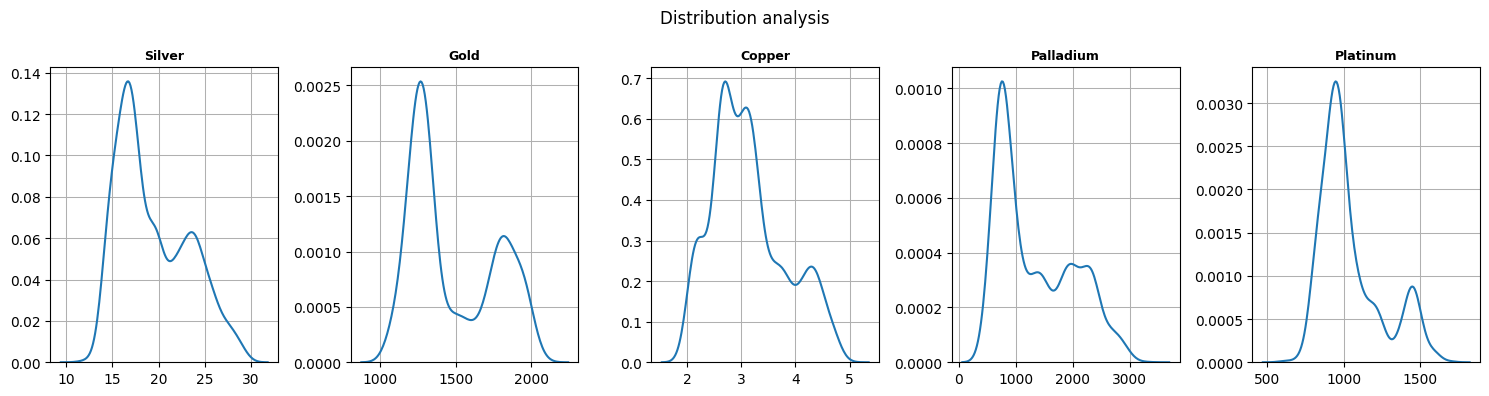

In [330]:
fig, axes = plt.subplots(1, 5, figsize = (15,4))

for i, m in enumerate(metals):
    ax = axes[i]
    sns.kdeplot(data = m, x = 'Price', ax = ax);
    ax.set_title(metals_name[i], fontsize = 9, fontweight= 'bold');
    ax.grid(visible=True, which = 'both', linewidth = 0.75);
    ax.set(xlabel = '', ylabel = '');
plt.suptitle(f"Distribution analysis");
plt.tight_layout();
plt.show();


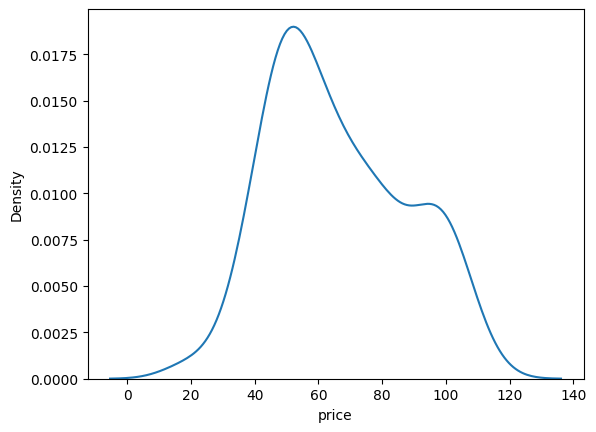

In [331]:
# Crude Oil Price
sns.kdeplot(crude_oil, x='price');

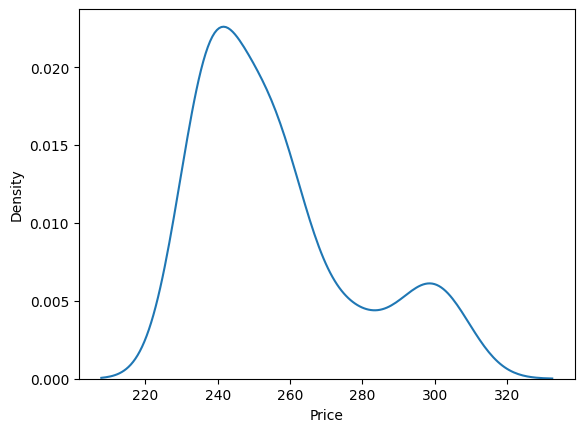

In [332]:
# US CPI
sns.kdeplot(us_cpi, x='Price');

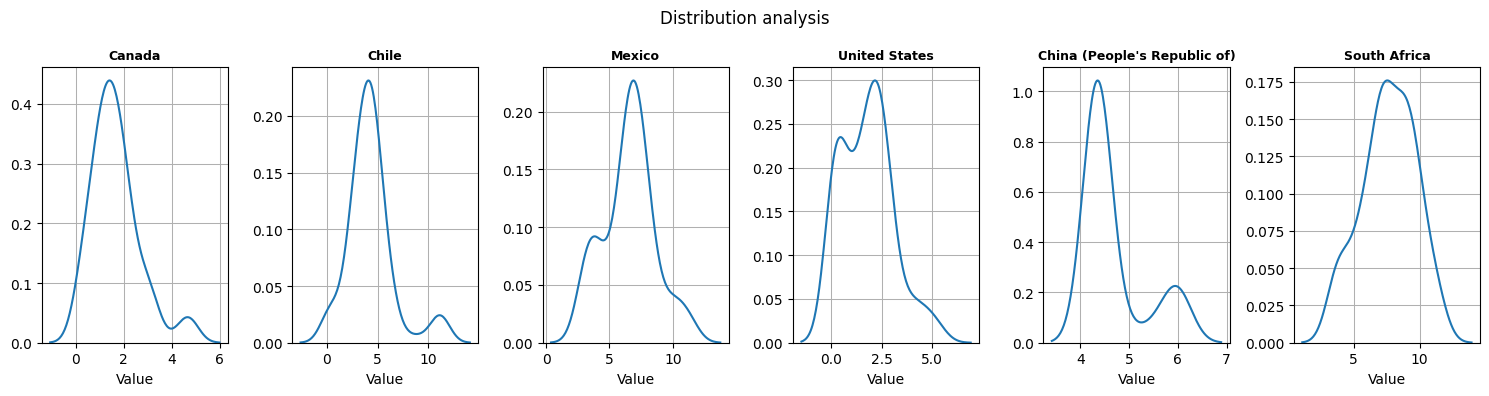

In [333]:
countries = interest_rates['Country'].unique()

fig, axes = plt.subplots(1, len(countries), figsize = (15,4))

for i, c in enumerate(countries):
    ax = axes[i]
    sns.kdeplot(data = interest_rates[interest_rates['Country'] == c], x = 'Value', ax = ax);
    ax.set_title(countries[i], fontsize = 9, fontweight= 'bold');
    ax.grid(visible=True, which = 'both', linewidth = 0.75);
    ax.set(xlabel = 'Value', ylabel = '');
plt.suptitle(f"Distribution analysis");
plt.tight_layout();
plt.show();

### Check null values

In [334]:
print(silver['Price'].isnull().sum())
print(gold['Price'].isnull().sum())
print(copper['Price'].isnull().sum())
print(palladium['Price'].isnull().sum())
print(platinum['Price'].isnull().sum())

0
0
0
0
0


In [335]:
print(us_cpi['Price'].isnull().sum())

3


In [336]:
us_cpi = us_cpi.fillna(method='ffill')

In [337]:
print(interest_rates['Value'].isnull().sum())

0


In [338]:
print(crude_oil['price'].isnull().sum())

0


In [339]:
gold.Date.min()

Timestamp('2013-02-12 00:00:00')

In [340]:
gold['Change %'].sum()

30.60000000000001

In [341]:
gold.drop_duplicates().reset_index(drop=True)

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-10-18,1964.3,1937.35,1975.45,1936.4,NaN,1.48
1,2023-10-17,1935.7,1933.30,1944.50,1924.6,165.06K,0.07
2,2023-10-16,1934.3,1941.30,1943.00,1921.2,182.82K,-0.37
3,2023-10-13,1941.5,1881.70,1946.20,1881.5,312.99K,3.11
4,2023-10-12,1883.0,1888.10,1898.30,1880.6,163.48K,-0.23
...,...,...,...,...,...,...,...
2761,2013-02-18,1604.2,1610.00,1618.80,1600.2,220.23K,-0.33
2762,2013-02-15,1609.5,1634.20,1636.00,1596.7,258.38K,-1.59
2763,2013-02-14,1635.5,1642.50,1650.00,1632.8,174.43K,-0.58
2764,2013-02-13,1645.1,1652.50,1655.00,1640.5,130.85K,-0.27


In [342]:
silver['Change %'].sum()

17.599999999999994

In [343]:
grouped = silver.groupby('Date').Price.max()
change = grouped.pct_change()*100
change.sum()

18.98739168077205

In [344]:
platinum.shape

(3318, 7)

## Transform data / Normalize time granularity

**Choose desired time granularity and apply to the rest of the data**

**Metals**

In [345]:
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

date_range = pd.date_range(
    min(silver['Date'].min(), platinum['Date'].min()), 
    max(silver['Date'].max(), platinum['Date'].max()), freq=us_bd
)

date_df = pd.DataFrame({'Date': date_range})

print(
    min(silver['Date'].min(), silver['Date'].min()), 
    max(silver['Date'].max(), silver['Date'].max())
)

merged_df_silver = pd.merge(date_df, silver, how='left', on='Date')
merged_df_gold = pd.merge(date_df, gold, how='left', on='Date')
merged_df_copper = pd.merge(date_df, copper, how='left', on='Date')
merged_df_palladium = pd.merge(date_df, palladium, how='left', on='Date')
merged_df_platinum = pd.merge(date_df, platinum, how='left', on='Date')

print("\nMissing values of silver:   ", merged_df_silver['Price'].isnull().sum())
print("Missing values of gold:      ", merged_df_gold['Price'].isnull().sum())
print("Missing values of copper:    ", merged_df_copper['Price'].isnull().sum())
print("Missing values of palladium: ", merged_df_palladium['Price'].isnull().sum())
print("Missing values of platinum:  ", merged_df_platinum['Price'].isnull().sum())

2013-02-18 00:00:00 2023-10-18 00:00:00

Missing values of silver:    26
Missing values of gold:       10
Missing values of copper:     7
Missing values of palladium:  8
Missing values of platinum:   8


In [346]:
merged_df_silver.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'], inplace=True)
merged_df_gold.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'], inplace=True)
merged_df_copper.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'], inplace=True)
merged_df_palladium.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'], inplace=True)
merged_df_platinum.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'], inplace=True)

In [347]:
imputer = SimpleImputer(strategy='mean')

columns = merged_df_silver.columns[1:]

imputed_df_silver = merged_df_silver.copy()
imputed_df_gold = merged_df_gold.copy()
imputed_df_copper = merged_df_copper.copy()
imputed_df_palladium = merged_df_palladium.copy()
imputed_df_platinum = merged_df_platinum.copy()

for c in columns:
    imputed_df_silver[c] = imputed_df_silver[c].interpolate(method='linear')
    imputed_df_gold[c] = imputed_df_gold[c].interpolate(method='linear')
    imputed_df_copper[c] = imputed_df_copper[c].interpolate(method='linear')
    imputed_df_palladium[c] = imputed_df_palladium[c].interpolate(method='linear')
    imputed_df_platinum[c] = imputed_df_platinum[c].interpolate(method='linear')


print("\nMissing values of silver:   ", imputed_df_silver['Price'].isnull().sum())
print("Missing values of gold:      ", imputed_df_gold['Price'].isnull().sum())
print("Missing values of copper:    ", imputed_df_copper['Price'].isnull().sum())
print("Missing values of palladium: ", imputed_df_palladium['Price'].isnull().sum())
print("Missing values of platinum:  ", imputed_df_platinum['Price'].isnull().sum())


Missing values of silver:    0
Missing values of gold:       0
Missing values of copper:     0
Missing values of palladium:  0
Missing values of platinum:   0


In [348]:
imputed_df_silver.shape

(2675, 2)

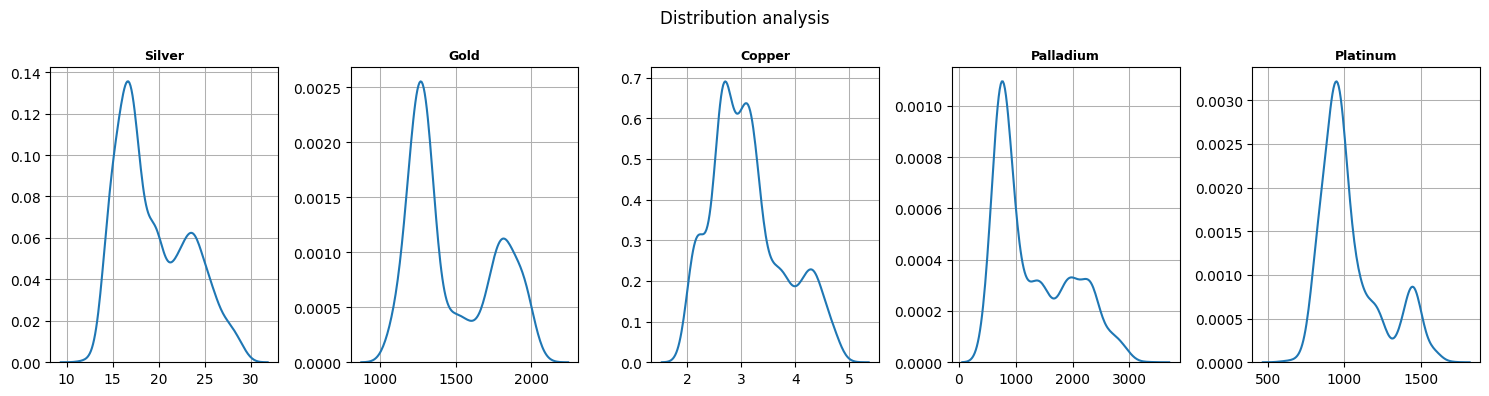

In [349]:
metals = [imputed_df_silver, imputed_df_gold, imputed_df_copper, imputed_df_palladium, imputed_df_platinum]
metals_name = ['Silver', 'Gold', 'Copper', 'Palladium', 'Platinum']
fig, axes = plt.subplots(1, 5, figsize = (15,4))

for i, m in enumerate(metals):
    ax = axes[i]
    sns.kdeplot(data = m, x = 'Price', ax = ax);
    ax.set_title(metals_name[i], fontsize = 9, fontweight= 'bold');
    ax.grid(visible=True, which = 'both', linewidth = 0.75);
    ax.set(xlabel = '', ylabel = '');
plt.suptitle(f"Distribution analysis");
plt.tight_layout();
plt.show();


**Interest Rates**

In [350]:
interest_rates.columns

Index(['LOCATION', 'Country', 'VARIABLE', 'Variable', 'FREQUENCY', 'Frequency',
       'TIME', 'Time', 'Unit Code', 'Unit', 'PowerCode Code', 'PowerCode',
       'Reference Period Code', 'Reference Period', 'Value', 'Flag Codes',
       'Flags'],
      dtype='object')

In [351]:
interest_rates.rename(columns={'TIME': 'Date', 'Value': 'Interest', 'VARIABLE': 'Interest_Type'}, inplace=True)
interest_rates.drop(columns=['LOCATION', 'FREQUENCY', 'Variable',
       'Frequency', 'Time', 'Unit Code', 'Unit', 'PowerCode Code',
       'PowerCode', 'Reference Period Code', 'Reference Period',
       'Flag Codes', 'Flags'], inplace=True)
interest_rates = interest_rates.pivot(index=['Country', 'Date'], columns='Interest_Type', values='Interest')
interest_rates.reset_index(inplace=True)
interest_rates.head()

Interest_Type,Country,Date,IRL,IRS
0,Canada,2013-04-01,1.964985,1.160667
1,Canada,2013-07-01,2.582537,1.168424
2,Canada,2013-10-01,2.583394,1.168606
3,Canada,2014-01-01,2.469459,1.170000
4,Canada,2014-04-01,2.352857,1.173968


In [352]:
interest_rates = interest_rates.pivot(index='Date', columns='Country', values=['IRL', 'IRS'])
interest_rates.columns = [f'{col[0]}_{col[1]}' for col in interest_rates.columns]
interest_rates.reset_index(inplace=True)
interest_rates.head()

,Date,IRL_Canada,IRL_Chile,IRL_China (People's Republic of),IRL_Mexico,IRL_South Africa,IRL_United States,IRS_Canada,IRS_Chile,IRS_China (People's Republic of),IRS_Mexico,IRS_South Africa,IRS_United States
0,2013-04-01,1.964985,5.241193,NaN,5.280000,7.284470,1.996667,1.160667,5.165688,6.0,3.816667,5.091102,0.196667
1,2013-07-01,2.582537,5.276933,NaN,6.518028,8.168377,2.710000,1.168424,5.294840,6.0,3.820000,5.091228,0.123333
2,2013-10-01,2.583394,5.087689,NaN,6.582194,8.115512,2.746667,1.168606,4.862149,6.0,3.453333,5.083428,0.126667
3,2014-01-01,2.469459,5.025218,NaN,6.730318,8.530106,2.763333,1.170000,4.404972,6.0,3.363333,5.504828,0.123333
4,2014-04-01,2.352857,4.910148,NaN,6.461151,8.302088,2.623333,1.173968,4.008386,6.0,3.290000,5.753463,0.113333


In [353]:
interest_rates.isnull().sum()

Date                                 0
IRL_Canada                           0
IRL_Chile                            0
IRL_China (People's Republic of)    42
IRL_Mexico                           0
IRL_South Africa                     0
IRL_United States                    0
IRS_Canada                           0
IRS_Chile                            0
IRS_China (People's Republic of)     0
IRS_Mexico                           0
IRS_South Africa                     0
IRS_United States                    0
dtype: int64

In [354]:
# Just to Visualize Interest Rates, melt 
melted_df = pd.melt(interest_rates, id_vars=['Date'], var_name='Country', value_name='Value')
melted_df['Date'] = pd.to_datetime(melted_df['Date'])
melted_df = melted_df.sort_values(['Date', 'Country']).reset_index(drop=True)
px.line(melted_df, x='Date', y='Value', color='Country')

In [355]:
# Merge by year and month
date_df['YearMonth'] = date_df['Date'].dt.to_period('M')
interest_rates['YearMonth'] = interest_rates['Date'].dt.to_period('M')
merged_df = pd.merge(date_df, interest_rates, on='YearMonth', how='left')
merged_df.drop(columns=['YearMonth', 'Date_y'], inplace=True)
merged_df.rename(columns={'Date_x': 'Date'}, inplace=True)
interest_rates.shape, merged_df.shape

((42, 14), (2675, 13))

<AxesSubplot: >

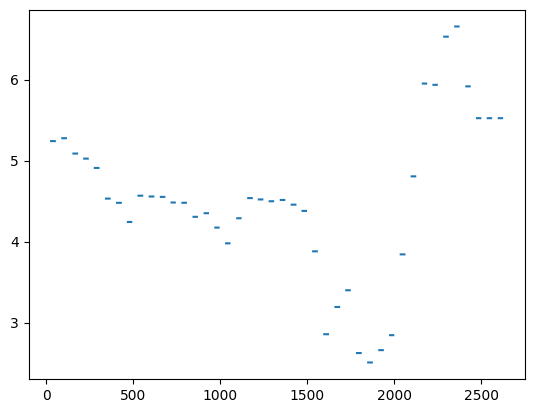

In [356]:
merged_df['IRL_Chile'].plot()

<AxesSubplot: >

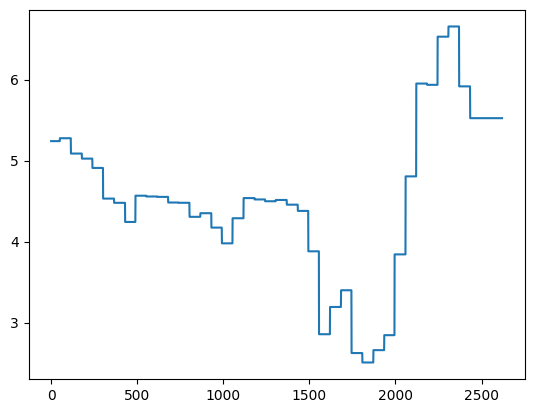

In [357]:
filled_df = merged_df.fillna(method='bfill')
filled_df['IRL_Chile'].plot()

<AxesSubplot: ylabel='Density'>

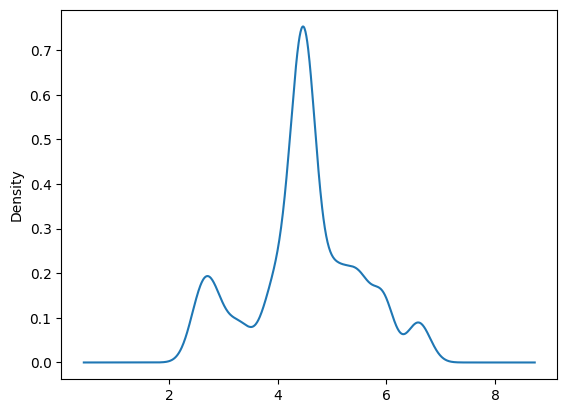

In [358]:
filled_df['IRL_Chile'].plot.kde()

**Oil Prices**

In [359]:
crude_oil = crude_oil.rename(columns={'date': 'Date', 'price': 'Oil_Price'}).drop(columns=['percentChange', 'change'])

<AxesSubplot: xlabel='Date', ylabel='Oil_Price'>

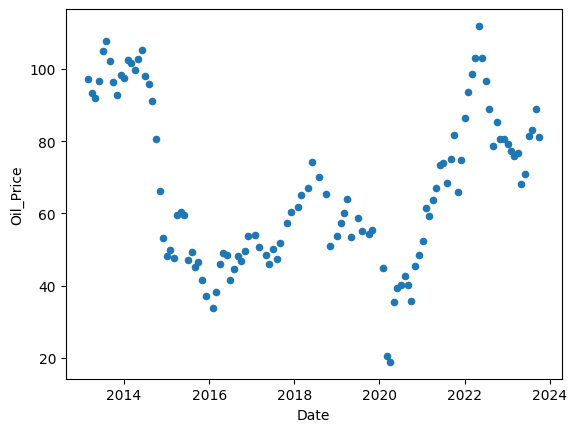

In [367]:
# Merge by date
merged_df = pd.merge(date_df, crude_oil, on='Date', how='left')
merged_df.plot.scatter(x='Date', y='Oil_Price')

<AxesSubplot: xlabel='Date'>

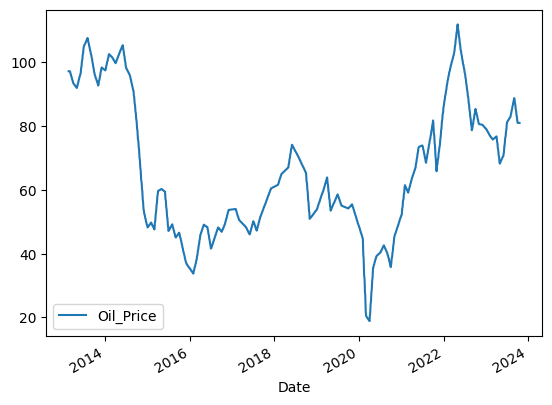

In [368]:
merged_df['Oil_Price'] = merged_df['Oil_Price'].interpolate(method='linear')
merged_df = merged_df.fillna(method='bfill')
merged_df.plot(x='Date', y='Oil_Price')

<AxesSubplot: ylabel='Density'>

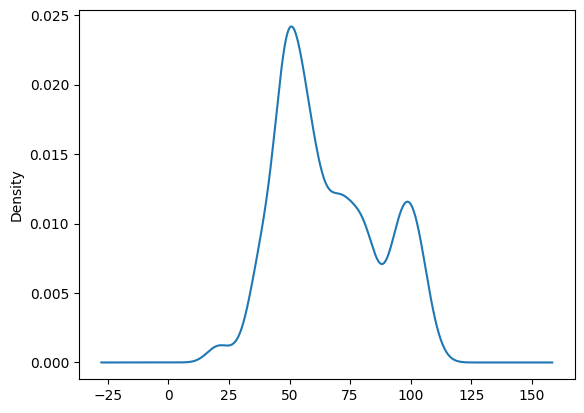

In [244]:
merged_df_interpolated.plot.kde()

**Consumer Price Index**

<AxesSubplot: xlabel='Date', ylabel='Price'>

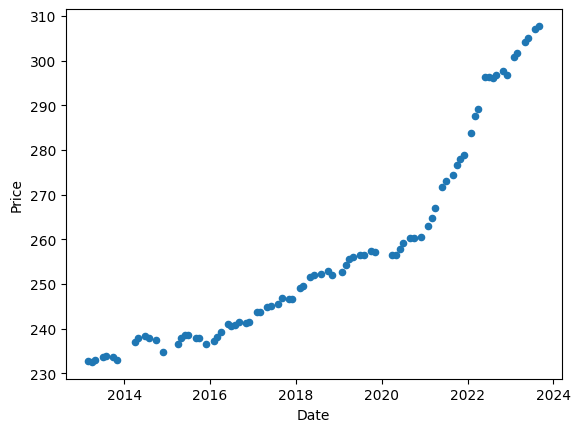

In [370]:
# Merge by date
merged_df = pd.merge(date_df, us_cpi, on='Date', how='left')
merged_df.plot.scatter(x='Date', y='Price')

<AxesSubplot: xlabel='Date'>

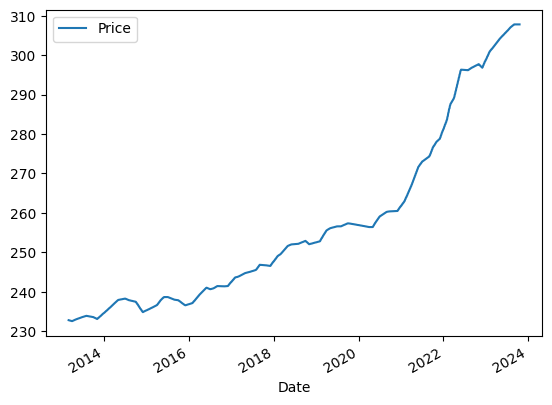

In [372]:
merged_df['Price'] = merged_df['Price'].interpolate(method='linear')
merged_df.plot(x='Date', y='Price')

In [374]:
merged_df

,Date,YearMonth,Year,Month,Price
0,2013-02-19,2013-02,NaN,NaN,NaN
1,2013-02-20,2013-02,NaN,NaN,NaN
2,2013-02-21,2013-02,NaN,NaN,NaN
3,2013-02-22,2013-02,NaN,NaN,NaN
4,2013-02-25,2013-02,NaN,NaN,NaN
...,...,...,...,...,...
2670,2023-10-12,2023-10,NaN,NaN,307.789
2671,2023-10-13,2023-10,NaN,NaN,307.789
2672,2023-10-16,2023-10,NaN,NaN,307.789
2673,2023-10-17,2023-10,NaN,NaN,307.789


<AxesSubplot: ylabel='Density'>

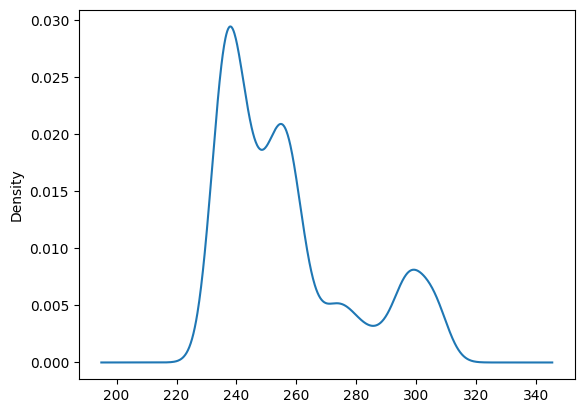

In [247]:
merged_df_interpolated.plot.kde()

### Strategy
- To make predictions I need the data updated to the last date, and as we've seen some data does not update regularly (like interests rates).
- A solution is to estimate the values using either imputation or some other technique, like time series prediction with ARIMA.
- But for the sake of the simplicity of this I would perform imputation.
- For this I would need 2 functions. 1) Function to preprocess the whole data to be inserted in the db when the application is started. 2) A function to update the data using the last date from the existent data.

### Wrap up preprocessing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lightgbm as lgb
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.impute import SimpleImputer

In [10]:
# Training preprocessing
def preprocessData():
    silver = pd.read_csv('datasets/Finance/Silver Futures Historical Data.csv')
    gold = pd.read_csv('datasets/Finance/Gold Futures Historical Data.csv')
    copper = pd.read_csv('datasets/Finance/Copper Futures Historical Data.csv')
    palladium = pd.read_csv('datasets/Finance/Palladium Futures Historical Data.csv')
    platinum = pd.read_csv('datasets/Finance/Platinum Futures Historical Data.csv')

    us_cpi = pd.read_csv('datasets/Finance/us cpi/cpi.csv')
    interest_rates = pd.read_csv("datasets/Finance/interestrates/EO_18102023022850125.csv")
    crude_oil = pd.read_csv("datasets/Finance/oil/crude-oil-price.csv")
    
    ### Preprocess Data
    silver['Date'] = pd.to_datetime(silver['Date'])
    gold['Date'] = pd.to_datetime(gold['Date'])
    copper['Date'] = pd.to_datetime(copper['Date'])
    palladium['Date'] = pd.to_datetime(palladium['Date'])
    platinum['Date'] = pd.to_datetime(platinum['Date'])

    def stringToNumber(data):
        df = data.copy()
        cols = df.columns
        for c in cols:
            if df[c].dtype == 'object':
                df[c] = df[c].str.replace('%', '')  # Remove percentage symbols
                df[c] = df[c].str.replace(',', '')  # Remove thousand separators
                df[c] = df[c].astype(float)  # Convert to float
        return df

    silver.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'], inplace=True)
    gold.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'], inplace=True)
    copper.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'], inplace=True)
    palladium.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'], inplace=True)
    platinum.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'], inplace=True)

    silver = stringToNumber(silver)
    gold= stringToNumber(gold)
    copper = stringToNumber(copper)
    palladium = stringToNumber(palladium)
    platinum = stringToNumber(platinum)

    crude_oil['date'] = pd.to_datetime(crude_oil['date'])

    interest_rates['TIME'] = pd.to_datetime(interest_rates['TIME'].str.replace('-', ''))

    us_cpi = pd.melt(us_cpi, id_vars=['Year'], var_name='Month', value_name='Price')
    us_cpi['Date'] = pd.to_datetime(us_cpi['Year'].astype(str) + '-' + us_cpi['Month'])
    us_cpi = us_cpi.fillna(method='ffill')

    min_date = silver['Date'].min()
    crude_oil = crude_oil[crude_oil['date'] >= min_date]
    interest_rates = interest_rates[interest_rates['TIME'] >= min_date]
    us_cpi = us_cpi[us_cpi['Date'] >= min_date]

    ### Date granularity

    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

    date_range = pd.date_range(
        silver['Date'].min(), 
        silver['Date'].max(),
        freq=us_bd
    )

    date_df = pd.DataFrame({'Date': date_range})

    ### Merge

    merged_df_silver = pd.merge(date_df, silver, how='left', on='Date')
    merged_df_gold = pd.merge(date_df, gold, how='left', on='Date')
    merged_df_copper = pd.merge(date_df, copper, how='left', on='Date')
    merged_df_palladium = pd.merge(date_df, palladium, how='left', on='Date')
    merged_df_platinum = pd.merge(date_df, platinum, how='left', on='Date')

    ### Impute

    imputer = SimpleImputer(strategy='mean')
    columns = ['Price']

    imputed_df_silver = merged_df_silver.copy()
    imputed_df_gold = merged_df_gold.copy()
    imputed_df_copper = merged_df_copper.copy()
    imputed_df_palladium = merged_df_palladium.copy()
    imputed_df_platinum = merged_df_platinum.copy()

    for c in columns:
        imputed_df_silver[c] = imputed_df_silver[c].interpolate(method='linear')
        imputed_df_gold[c] = imputed_df_gold[c].interpolate(method='linear')
        imputed_df_copper[c] = imputed_df_copper[c].interpolate(method='linear')
        imputed_df_palladium[c] = imputed_df_palladium[c].interpolate(method='linear')
        imputed_df_platinum[c] = imputed_df_platinum[c].interpolate(method='linear')

    imputed_df_silver.rename(columns={'Price': 'Silver_Price'}, inplace=True)
    imputed_df_gold.rename(columns={'Price': 'Gold_Price'}, inplace=True)
    imputed_df_copper.rename(columns={'Price': 'Copper_Price'}, inplace=True)
    imputed_df_palladium.rename(columns={'Price': 'Palladium_Price'}, inplace=True)
    imputed_df_platinum.rename(columns={'Price': 'Platinum_Price'}, inplace=True)

    # Interest Rates
    interest_rates.rename(columns={'TIME': 'Date', 'Value': 'Interest', 'VARIABLE': 'Interest_Type'}, inplace=True)
    interest_rates.drop(columns=['LOCATION', 'FREQUENCY', 'Variable',
        'Frequency', 'Time', 'Unit Code', 'Unit', 'PowerCode Code',
        'PowerCode', 'Reference Period Code', 'Reference Period',
        'Flag Codes', 'Flags'], inplace=True)
    interest_rates = interest_rates.pivot(index=['Country', 'Date'], columns='Interest_Type', values='Interest')
    interest_rates.reset_index(inplace=True)
    interest_rates = interest_rates.pivot(index='Date', columns='Country', values=['IRL', 'IRS'])
    interest_rates.columns = [f'{col[0]}_{col[1]}' for col in interest_rates.columns]
    interest_rates.reset_index(inplace=True)
    date_df['YearMonth'] = date_df['Date'].dt.to_period('M')
    interest_rates['YearMonth'] = interest_rates['Date'].dt.to_period('M')
    merged_df_interest_rates = pd.merge(date_df, interest_rates, on='YearMonth', how='left')
    merged_df_interest_rates.drop(columns=['YearMonth', 'Date_y'], inplace=True)
    merged_df_interest_rates.rename(columns={'Date_x': 'Date'}, inplace=True)
    merged_df_interest_rates.drop(columns="IRL_China (People's Republic of)", inplace=True)

    # Crude Oil
    crude_oil = crude_oil.rename(columns={'date': 'Date', 'price': 'Oil_Price'}).drop(columns=['percentChange', 'change'])
    merged_df_crude_oil = pd.merge(date_df, crude_oil, on='Date', how='left')
    merged_df_crude_oil['Oil_Price'] = merged_df_crude_oil['Oil_Price'].interpolate(method='linear')
    merged_df_crude_oil.drop(columns='YearMonth', inplace=True)

    # Us CPI
    merged_df_us_cpi = pd.merge(date_df, us_cpi, on='Date', how='left')
    merged_df_us_cpi.drop(columns=['YearMonth', 'Year', 'Month'], inplace=True)
    merged_df_us_cpi['Price'] = merged_df_us_cpi['Price'].interpolate(method='linear')
    merged_df_us_cpi.rename(columns={'Price': 'US_CPI'}, inplace=True)

    # Impute
    imputed_df_interest_rates = merged_df_interest_rates.fillna(method='bfill')
    imputed_df_crude_oil = merged_df_crude_oil.fillna(method='bfill')
    imputed_df_us_cpi = merged_df_us_cpi.fillna(method='bfill')

    df_list = [imputed_df_silver, imputed_df_gold, imputed_df_copper, imputed_df_palladium, imputed_df_platinum, imputed_df_interest_rates, imputed_df_crude_oil, imputed_df_us_cpi]

    merged_df = df_list[0]
    for df in df_list[1:]:
        merged_df = pd.merge(merged_df, df, on='Date', how='inner')

    return merged_df

### How to handle data updates at different times.


In [15]:
dfs = preprocessData()

dfs.isnull().sum()

Date                                 0
Silver_Price                         0
Gold_Price                           0
Copper_Price                         0
Palladium_Price                      0
Platinum_Price                       0
IRL_Canada                          55
IRL_Chile                           55
IRL_Mexico                          55
IRL_South Africa                    55
IRL_United States                   55
IRS_Canada                          55
IRS_Chile                           55
IRS_China (People's Republic of)    55
IRS_Mexico                          55
IRS_South Africa                    55
IRS_United States                   55
Oil_Price                            0
US_CPI                               0
dtype: int64

In [54]:
test_df = dfs.copy()
test_df['Year'] = test_df['Date'].dt.year
test_df['Month'] = test_df['Date'].dt.month
test_df['Day'] = test_df['Date'].dt.day
test_df = test_df.set_index('Date')
test_df.tail()

,Silver_Price,Gold_Price,Copper_Price,Palladium_Price,Platinum_Price,IRL_Canada,IRL_Chile,IRL_Mexico,IRL_South Africa,IRL_United States,...,IRS_Chile,IRS_China (People's Republic of),IRS_Mexico,IRS_South Africa,IRS_United States,Oil_Price,US_CPI,Year,Month,Day
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-12,21.959,1883.0,3.5910,1143.00,875.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,81.02,307.789,2023,10,12
2023-10-13,22.895,1941.5,3.5710,1151.50,884.2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,81.02,307.789,2023,10,13
2023-10-16,22.765,1934.3,3.5820,1146.80,899.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,81.02,307.789,2023,10,16
2023-10-17,23.024,1935.7,3.5785,1146.70,906.2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,81.02,307.789,2023,10,17
2023-10-18,23.038,1964.3,3.5845,1137.78,892.1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,81.02,307.789,2023,10,18


In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

def fill_missing_values_with_model(df, target_column, feature_columns):
    #df = target_df.copy()
    # Separate rows with missing and non-missing values
    df_missing = df[df[target_column].isnull()]
    df_not_missing = df.dropna(subset=[target_column])
    
    # Prepare data for the model
    X = df_not_missing[feature_columns].values.reshape(-1, len(feature_columns))
    y = df_not_missing[target_column].values
    
    # Create and fit the model
    model = DecisionTreeRegressor()
    model.fit(X, y)
    
    # Predict missing values
    X_missing = df_missing[feature_columns].values.reshape(-1, len(feature_columns))
    predicted_values = model.predict(X_missing)
    
    # Fill missing values in the DataFrame
    df.loc[df[target_column].isnull(), target_column] = predicted_values

# Fill the df
columns_with_missing_values = test_df.columns[test_df.isnull().any()].tolist()
columns_without_missing_values = test_df.columns[~test_df.isnull().any()].tolist()

feature_columns = columns_without_missing_values

for c in columns_with_missing_values:
    fill_missing_values_with_model(test_df, c, feature_columns)

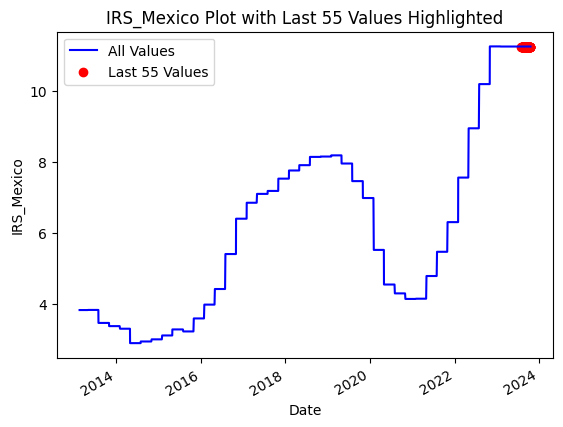

In [64]:
were_missing = 55
column = columns_with_missing_values[8]
ax = test_df.plot(y=column, color='blue', label='All Values')
last_w_values = test_df.tail(were_missing)
ax.scatter(last_w_values.index, last_w_values[column], color='red', label=f'Last {were_missing} Values')
plt.title(f'{column} Plot with Last {were_missing} Values Highlighted')
plt.xlabel('Date')
plt.ylabel(column)
plt.legend()
plt.show()

In [65]:
test_df.tail()

,Silver_Price,Gold_Price,Copper_Price,Palladium_Price,Platinum_Price,IRL_Canada,IRL_Chile,IRL_Mexico,IRL_South Africa,IRL_United States,...,IRS_Chile,IRS_China (People's Republic of),IRS_Mexico,IRS_South Africa,IRS_United States,Oil_Price,US_CPI,Year,Month,Day
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-12,21.959,1883.0,3.5910,1143.00,875.8,3.16273,5.524478,10.15,11.431235,4.4,...,11.262855,4.3,11.25,7.213956,5.35,81.02,307.789,2023,10,12
2023-10-13,22.895,1941.5,3.5710,1151.50,884.2,3.16273,5.524478,10.15,11.431235,4.4,...,11.262855,4.3,11.25,7.213956,5.35,81.02,307.789,2023,10,13
2023-10-16,22.765,1934.3,3.5820,1146.80,899.4,3.16273,5.524478,10.15,11.431235,4.4,...,11.262855,4.3,11.25,7.213956,5.35,81.02,307.789,2023,10,16
2023-10-17,23.024,1935.7,3.5785,1146.70,906.2,3.16273,5.524478,10.15,11.431235,4.4,...,11.262855,4.3,11.25,7.213956,5.35,81.02,307.789,2023,10,17
2023-10-18,23.038,1964.3,3.5845,1137.78,892.1,3.16273,5.524478,10.15,11.431235,4.4,...,11.262855,4.3,11.25,7.213956,5.35,81.02,307.789,2023,10,18


In [67]:
test_df.reset_index().to_csv('dataset.csv', index=None)

## First experiment / Baseline

In [81]:
data = test_df.copy()
target = 'Silver_Price'
data.tail()

,Silver_Price,Gold_Price,Copper_Price,Palladium_Price,Platinum_Price,IRL_Canada,IRL_Chile,IRL_Mexico,IRL_South Africa,IRL_United States,...,IRS_Chile,IRS_China (People's Republic of),IRS_Mexico,IRS_South Africa,IRS_United States,Oil_Price,US_CPI,Year,Month,Day
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-12,21.959,1883.0,3.5910,1143.00,875.8,3.16273,5.524478,10.15,11.431235,4.4,...,11.262855,4.3,11.25,7.213956,5.35,81.02,307.789,2023,10,12
2023-10-13,22.895,1941.5,3.5710,1151.50,884.2,3.16273,5.524478,10.15,11.431235,4.4,...,11.262855,4.3,11.25,7.213956,5.35,81.02,307.789,2023,10,13
2023-10-16,22.765,1934.3,3.5820,1146.80,899.4,3.16273,5.524478,10.15,11.431235,4.4,...,11.262855,4.3,11.25,7.213956,5.35,81.02,307.789,2023,10,16
2023-10-17,23.024,1935.7,3.5785,1146.70,906.2,3.16273,5.524478,10.15,11.431235,4.4,...,11.262855,4.3,11.25,7.213956,5.35,81.02,307.789,2023,10,17
2023-10-18,23.038,1964.3,3.5845,1137.78,892.1,3.16273,5.524478,10.15,11.431235,4.4,...,11.262855,4.3,11.25,7.213956,5.35,81.02,307.789,2023,10,18


In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.utils import shuffle

X = data.drop(columns=target)
y = data[target]

X, y = shuffle(X, y, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with preprocessing and a regression model
def create_regression_pipeline(model):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardize features
        ('regressor', model)  # Choose the regression model (Linear, RandomForest, GradientBoosting)
    ])
    return pipeline

linear_reg_model = LinearRegression()
random_forest_model = RandomForestRegressor()
gradient_boosting_model = GradientBoostingRegressor()
svr_model = SVR()
knn_model = KNeighborsRegressor()
lgbm_model = LGBMRegressor()
xgb_model = XGBRegressor()


# Adjust the weights to favor the Random Forest Regressor
voting_regressor_weighted = VotingRegressor([
    ('random_forest', random_forest_model),
    ('lgbm', lgbm_model),
    ('xgb', xgb_model)
])

# List of models to evaluate
models = [linear_reg_model, random_forest_model, gradient_boosting_model, 
          voting_regressor_weighted, svr_model, knn_model, lgbm_model, xgb_model]


# Perform cross-validation for each model
for model in models:
    pipeline = create_regression_pipeline(model)
    
    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    
    # Print the average cross-validation score for each model
    print(f'Model: {model.__class__.__name__}')
    print(f'Cross-Validation Mean Squared Error: {-cv_scores.mean()}')
    print('---')


Model: LinearRegression
Cross-Validation Mean Squared Error: 0.8165386284009843
---
Model: RandomForestRegressor
Cross-Validation Mean Squared Error: 0.08113533002398388
---
Model: GradientBoostingRegressor
Cross-Validation Mean Squared Error: 0.21033425844377454
---
Model: VotingRegressor
Cross-Validation Mean Squared Error: 0.07641652273009573
---
Model: SVR
Cross-Validation Mean Squared Error: 0.33247046375330597
---
Model: KNeighborsRegressor
Cross-Validation Mean Squared Error: 0.26317839812149535
---
Model: LGBMRegressor
Cross-Validation Mean Squared Error: 0.10022045608348759
---
Model: XGBRegressor
Cross-Validation Mean Squared Error: 0.1074549974715641
---


Best score: Cross-Validation Mean Squared Error: 0.07641652273009573

### Feature Engineering Test

**Considerations**

- I removed the Silver based features to capture the power of the other features.

In [128]:
data = test_df.copy().reset_index()
target = 'Silver_Price'

# Convert 'Date' to datetime and create date-related features
data['Date'] = pd.to_datetime(data['Date'])
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['IsWeekend'] = data['DayOfWeek'].isin([5, 6]).astype(int)
data['Quarter'] = data['Date'].dt.quarter

# Calculate metal price ratios
#data['Gold_to_Silver_Ratio'] = data['Gold_Price'] / data['Silver_Price']
data['Platinum_to_Palladium_Ratio'] = data['Platinum_Price'] / data['Palladium_Price']
data['Copper_to_Gold_Ratio'] = data['Copper_Price'] / data['Gold_Price']
data['Platinum_to_Gold_Ratio'] = data['Platinum_Price'] / data['Gold_Price']
#data['Palladium_to_Silver_Ratio'] = data['Palladium_Price'] / data['Silver_Price']

# Calculate rolling averages for metal prices
#data['Silver_Price_Mean_7'] = data['Silver_Price'].rolling(window=7).mean()
data['Gold_Price_Mean_7'] = data['Gold_Price'].rolling(window=7).mean()
data['Copper_Price_Mean_7'] = data['Copper_Price'].rolling(window=7).mean()
data['Palladium_Price_Mean_7'] = data['Palladium_Price'].rolling(window=7).mean()
data['Platinum_Price_Mean_7'] = data['Platinum_Price'].rolling(window=7).mean()

#data['Silver_Price_Mean_15'] = data['Silver_Price'].rolling(window=15).mean()
data['Gold_Price_Mean_15'] = data['Gold_Price'].rolling(window=15).mean()
data['Copper_Price_Mean_15'] = data['Copper_Price'].rolling(window=15).mean()
data['Palladium_Price_Mean_15'] = data['Palladium_Price'].rolling(window=15).mean()
data['Platinum_Price_Mean_15'] = data['Platinum_Price'].rolling(window=15).mean()

# Calculate the Real Interest Rate (assuming nominal interest rate minus inflation rate)
data['Real_Interest_Rate_Canada'] = data['IRL_Canada'] - data['US_CPI']
data['Real_Interest_Rate_Chile'] = data['IRL_Chile'] - data['US_CPI']
data['Real_Interest_Rate_Mexico'] = data['IRL_Mexico'] - data['US_CPI']
data['Real_Interest_Rate_South_Africa'] = data['IRL_South Africa'] - data['US_CPI']
data['Real_Interest_Rate_United_States'] = data['IRL_United States'] - data['US_CPI']

# Calculate the Change in Oil Price
data['Oil_Price_Change'] = data['Oil_Price'].diff()

#lags=1
#data[target + '_Lagged'] = data[target].shift(lags)

data = data.set_index('Date')

data.shape, data.isnull().sum().sum()

((2675, 41), 81)

In [129]:
data = data.dropna(axis=0)
data.shape, data.isnull().sum().sum()

((2661, 41), 0)

In [130]:
X = data.drop(columns=target)
y = data[target]

X, y = shuffle(X, y, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def create_regression_pipeline(model):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
    return pipeline

voting_regressor_weighted = VotingRegressor([
    ('random_forest', random_forest_model),
    ('lgbm', lgbm_model),
    ('xgb', xgb_model)
])

cv_scores = cross_val_score(create_regression_pipeline(voting_regressor_weighted), X_train, y_train, cv=10, scoring='neg_mean_squared_error')

print(f'Model: {model.__class__.__name__}')
print(f'Cross-Validation Mean Squared Error: {-cv_scores.mean()}')
print('---')

Model: XGBRegressor
Cross-Validation Mean Squared Error: 0.07289454677204213
---


Best Score: Cross-Validation Mean Squared Error: 0.07289454677204213


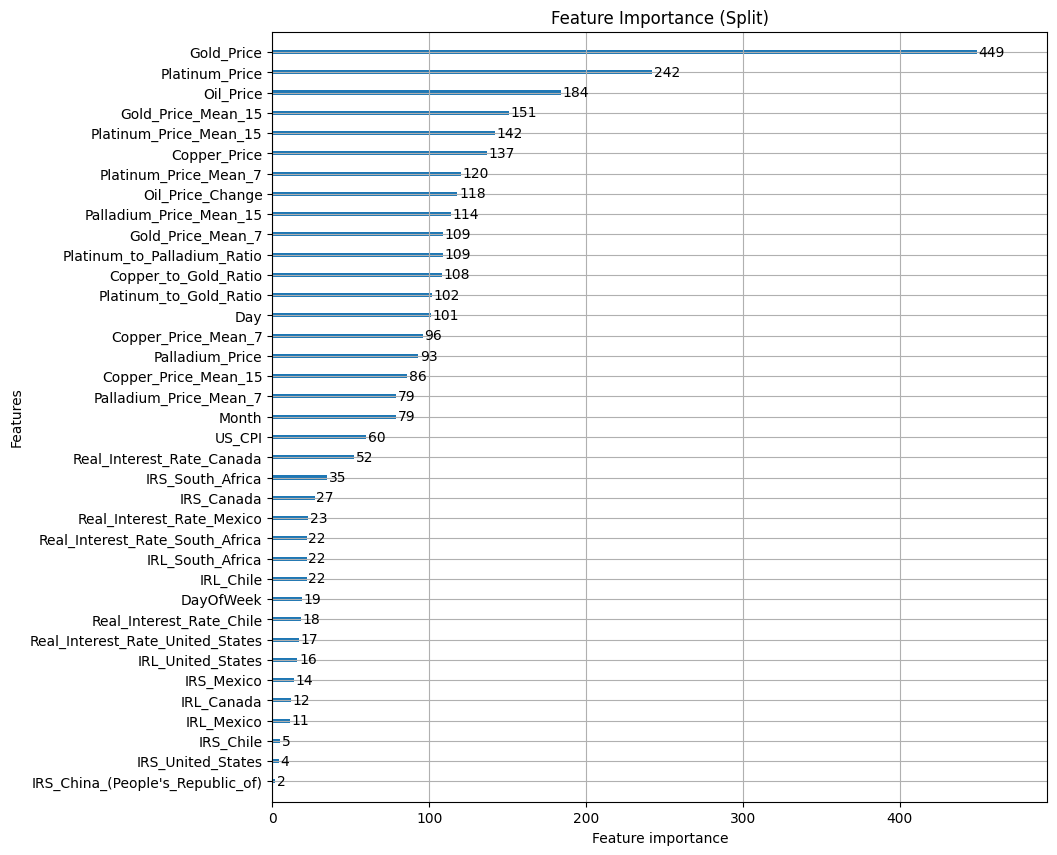

In [126]:
# Assuming you have the trained LGBMRegressor model
lgbm_model = LGBMRegressor()

# Assuming 'X_train' is your training data
# Fit the LGBMRegressor model
lgbm_model.fit(X_train, y_train)

# Plot feature importances
lgb.plot_importance(lgbm_model, importance_type='split', title='Feature Importance (Split)', figsize=(10,10))
plt.show()

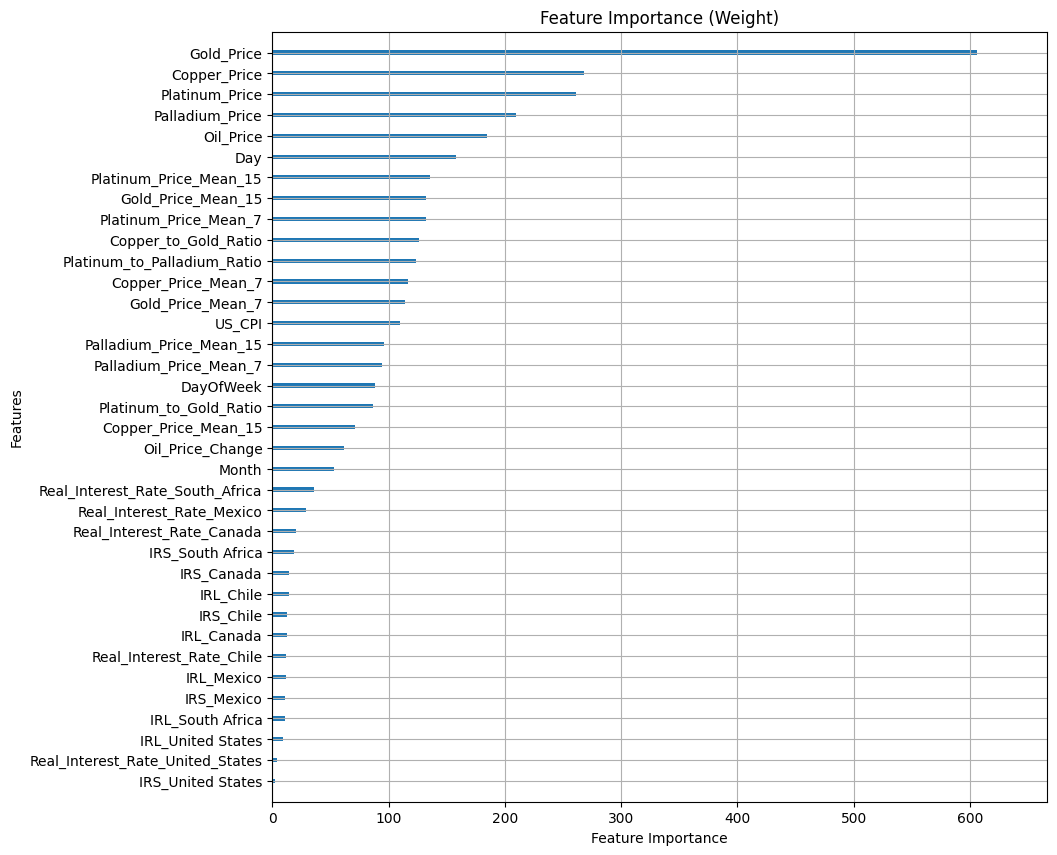

In [127]:
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming you have the trained XGBRegressor model
xgb_model = XGBRegressor()

# Assuming 'X_train' is your training data
# Fit the XGBRegressor model
xgb_model.fit(X_train, y_train)

plt.rcParams['figure.figsize'] = (10, 10)

# Use 'feature_names' parameter in plot_importance
xgb.plot_importance(xgb_model, importance_type='weight', title='Feature Importance (Weight)', 
                    xlabel='Feature Importance', ylabel='Features', show_values=False)

plt.show()
